# Seq2Seq Sales and Additional Features

In [1]:
import os
from sklearn.metrics import mean_absolute_error
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

# seq2seq model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import os
# from google.colab import drive, files
# drive.mount('/content/gdrive')
%matplotlib inline

import seaborn as sns
sns.set()



Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if np.isfinite(mape):
        return mape
    else:
        return np.NaN

In [4]:
for line in ["%s = np.load('../data/%s')" % (f.replace('.npz',''),f) for f in os.listdir('../data') if 'npz' in f]:
    print(line)

promo_tensors = np.load('../data/promo_tensors.npz')
store_item_tensors = np.load('../data/store_item_tensors.npz')
dt_tensors = np.load('../data/dt_tensors.npz')
oil_tensors = np.load('../data/oil_tensors.npz')
item_tensors = np.load('../data/item_tensors.npz')
store_tensors = np.load('../data/store_tensors.npz')


In [5]:
for line in ["%s = %s.f.arr_0" % (f.replace('.npz',''),f.replace('.npz','')) for f in os.listdir('../data') if 'npz' in f]:
    print(line)

promo_tensors = promo_tensors.f.arr_0
store_item_tensors = store_item_tensors.f.arr_0
dt_tensors = dt_tensors.f.arr_0
oil_tensors = oil_tensors.f.arr_0
item_tensors = item_tensors.f.arr_0
store_tensors = store_tensors.f.arr_0


In [6]:
df = pd.read_pickle('../data/all_sales_df.pkl')
# exog_array = np.load('/home/ec2-user/SageMaker/timeseries/notebooks/4w_preds/data/overlap_raleys_12w_dt_exo.npz')
# exog_array = exog_array.f.arr_0

In [7]:
! ls ../data

all_sales_df.pkl  item_tensors.npz  promo_tensors.npz	    store_tensors.npz
dt_tensors.npz	  oil_tensors.npz   store_item_tensors.npz


In [8]:
def create_exog_array():
    promo_tensors = np.load('../data/promo_tensors.npz')
    dt_tensors = np.load('../data/dt_tensors.npz')
    store_item_tensors = np.load('../data/store_item_tensors.npz')
    oil_tensors = np.load('../data/oil_tensors.npz')
#     item_tensors = np.load('../data/item_tensors.npz')
#     store_tensors = np.load('../data/store_tensors.npz')

    promo_tensors = promo_tensors.f.arr_0
    dt_tensors = dt_tensors.f.arr_0
    store_item_tensors = store_item_tensors.f.arr_0
    oil_tensors = oil_tensors.f.arr_0
#     item_tensors = item_tensors.f.arr_0
#     store_tensors = store_tensors.f.arr_0

    return np.concatenate([
        promo_tensors,
        dt_tensors,
        store_item_tensors,
        oil_tensors,
#         item_tensors,
#         store_tensors
    ] ,axis=-1)

In [9]:
exog_array = create_exog_array()

In [10]:
exog_array.shape

(8715, 1572, 183)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8715 entries, 0 to 8714
Columns: 1573 entries, store_item to 2017-07-04 00:00:00
dtypes: float64(1572), object(1)
memory usage: 104.6+ MB
Data ranges from 2013-03-16 00:00:00 to 2017-07-04 00:00:00


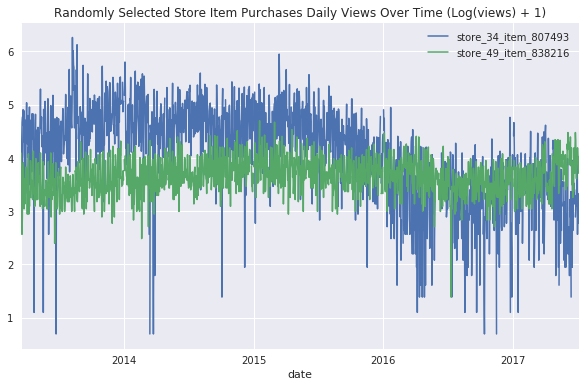

In [11]:
df.info()

data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['store_item'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Store Item Purchases Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 2)

In [12]:
df.head()

date,store_item,2013-03-16 00:00:00,2013-03-17 00:00:00,2013-03-18 00:00:00,2013-03-19 00:00:00,2013-03-20 00:00:00,2013-03-21 00:00:00,2013-03-22 00:00:00,2013-03-23 00:00:00,2013-03-24 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
0,store_47_item_581078,57.0,66.0,31.0,28.0,29.0,29.0,41.0,54.0,60.0,...,114.0,55.0,40.0,53.0,54.0,111.0,99.0,131.0,109.0,72.0
1,store_46_item_265559,186.0,287.0,136.0,106.0,104.0,71.0,73.0,207.0,228.0,...,204.0,89.0,65.0,71.0,67.0,109.0,241.0,260.0,122.0,160.0
2,store_37_item_364606,83.0,64.0,76.0,42.0,81.0,33.0,46.0,73.0,38.0,...,33.0,18.0,21.0,24.0,17.0,30.0,37.0,35.0,30.0,32.0
3,store_46_item_213652,25.0,40.0,13.0,11.0,20.0,6.0,11.0,29.0,20.0,...,17.0,9.0,2.0,14.0,8.0,16.0,32.0,29.0,8.0,11.0
4,store_46_item_213788,28.0,34.0,13.0,18.0,13.0,10.0,21.0,25.0,37.0,...,17.0,9.0,3.0,6.0,14.0,13.0,9.0,25.0,3.0,11.0


In [13]:
from datetime import timedelta

pred_steps = 28 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2013-03-16 00:00:00 - 2017-05-09 00:00:00
Train prediction: 2017-05-10 00:00:00 - 2017-06-06 00:00:00 

Val encoding: 2013-04-13 00:00:00 - 2017-06-06 00:00:00
Val prediction: 2017-06-07 00:00:00 - 2017-07-04 00:00:00

Encoding interval: 1516
Prediction interval: 28


In [14]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [15]:
def get_data_encode_decode(series_array, exog_array, first_n_samples,
                           date_to_index, enc_start, enc_end, pred_start, pred_end):

    exog_inds = date_to_index[enc_start:pred_end]
    
    # sample of series from enc_start to enc_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               enc_start, enc_end)[:first_n_samples]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from pred_start to pred_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                pred_start, pred_end)[:first_n_samples]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # we append a lagged history of the target series to the input data, 
    # so that we can train with teacher forcing
    lagged_target_history = decoder_target_data[:,:-1,:1]
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # we add the exogenous features corresponding to day after input series
    # values to the input data (exog should match day we are predicting)
    exog_input_data = exog_array[:first_n_samples,exog_inds,:][:,1:,:]
    encoder_input_data = np.concatenate([encoder_input_data, exog_input_data], axis=-1)
    
    return encoder_input_data, decoder_target_data, encode_series_mean

In [16]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.FATAL) # suppress unhelpful tf warnings

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
# Note the feature input dimension corresponds to the raw series and all exogenous features  
history_seq = Input(shape=(None, 1 + exog_array.shape[-1]))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 184)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     5920        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     2080        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     2080        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [18]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [19]:
first_n_samples = 3000
# first_n_samples = len(df)
# first_n_samples = 2000
batch_size = 200
epochs = 1000

encoder_input_data, decoder_target_data, encode_series_mean = \
    get_data_encode_decode(series_array, exog_array, first_n_samples, date_to_index, 
                           train_enc_start, train_enc_end, train_pred_start, train_pred_end)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,  validation_split=0.2, callbacks=[early_stop],
                    epochs=epochs, shuffle=True)

Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 67s 28ms/step - loss: 0.4424 - val_loss: 0.4787
Epoch 2/1000
2400/2400 [==============================] - 22s 9ms/step - loss: 0.4156 - val_loss: 0.4710
Epoch 3/1000
2400/2400 [==============================] - 22s 9ms/step - loss: 0.3949 - val_loss: 0.4487
Epoch 4/1000
2400/2400 [==============================] - 23s 9ms/step - loss: 0.3742 - val_loss: 0.4350
Epoch 5/1000
2400/2400 [==============================] - 22s 9ms/step - loss: 0.3609 - val_loss: 0.4268
Epoch 6/1000
2400/2400 [==============================] - 23s 9ms/step - loss: 0.3520 - val_loss: 0.4224
Epoch 7/1000
2400/2400 [==============================] - 23s 9ms/step - loss: 0.3451 - val_loss: 0.4215
Epoch 8/1000
2400/2400 [==============================] - 22s 9ms/step - loss: 0.3404 - val_loss: 0.4162
Epoch 9/1000
2400/2400 [==============================] - 23s 9ms/step - loss: 0.3362 - val_loss: 0.4166
Epoch 1

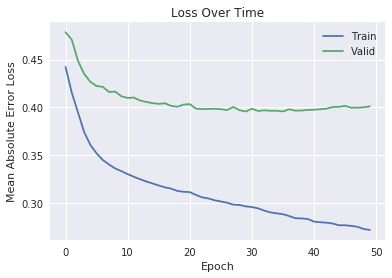

In [20]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# visualize predictions between val_pred_start, val_pred_end

In [20]:
def predict_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

In [25]:
# from keras.models import load_model

# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [16]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [17]:
encoder_input_data, decoder_target_data, encode_series_mean = \
    get_data_encode_decode(series_array, exog_array, df.shape[0], date_to_index, 
                           val_enc_start, val_enc_end, val_pred_start, val_pred_end)

In [18]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, actual, enc_tail_len=50):

    encode_tensor = encoder_input_data[[sample_ind],:,:] 
    pred_series = predict_sequence(encode_tensor)
    
    encode_series = encode_tensor[:,:(-pred_steps+1),0].reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(30,6))  
    
    if actual:
      # target is in orange and transformed by adding the mean and then expm1
      plt.plot(pd.date_range(start=val_pred_start,freq='D',periods=pred_steps), np.expm1(target_series + encode_series_mean[sample_ind]),color='orange')
      # teal is predicted
      plt.plot(pd.date_range(start=val_pred_start,freq='D',periods=pred_steps), np.expm1(pred_series + encode_series_mean[sample_ind]),color='teal',linestyle='--')
      # blue is the training a certain amount of days before validation starts
      plt.plot(pd.date_range(start=val_enc_start, end=val_enc_end+timedelta(1),freq='D')[-(x_encode+1):][1:], np.expm1(encode_series_tail + encode_series_mean[sample_ind] ))
    
    else:
      plt.plot(range(1,x_encode+1),encode_series_tail)
      plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
      plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    
    display(pd.DataFrame({'ds': pd.date_range(start=val_pred_start,freq='D',periods=pred_steps), 
              'actual': np.expm1(target_series + encode_series_mean[sample_ind]).flatten(),
              'pred': np.expm1(pred_series + encode_series_mean[sample_ind]).flatten()
             }).set_index('ds').T)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,30.000000,19.000000,48.000000,43.000000,45.000000,26.000000,26.000000,32.00000,32.000000,50.000000,...,114.00000,55.00000,40.000000,53.000000,54.00000,111.000000,99.000000,131.000000,109.000000,72.000000
pred,38.709572,27.204282,47.433545,44.207985,60.398454,37.730109,32.519941,41.15706,24.718119,48.764545,...,83.08502,58.67313,50.310042,65.279805,37.32169,70.145782,68.225632,84.866183,60.015655,50.408512


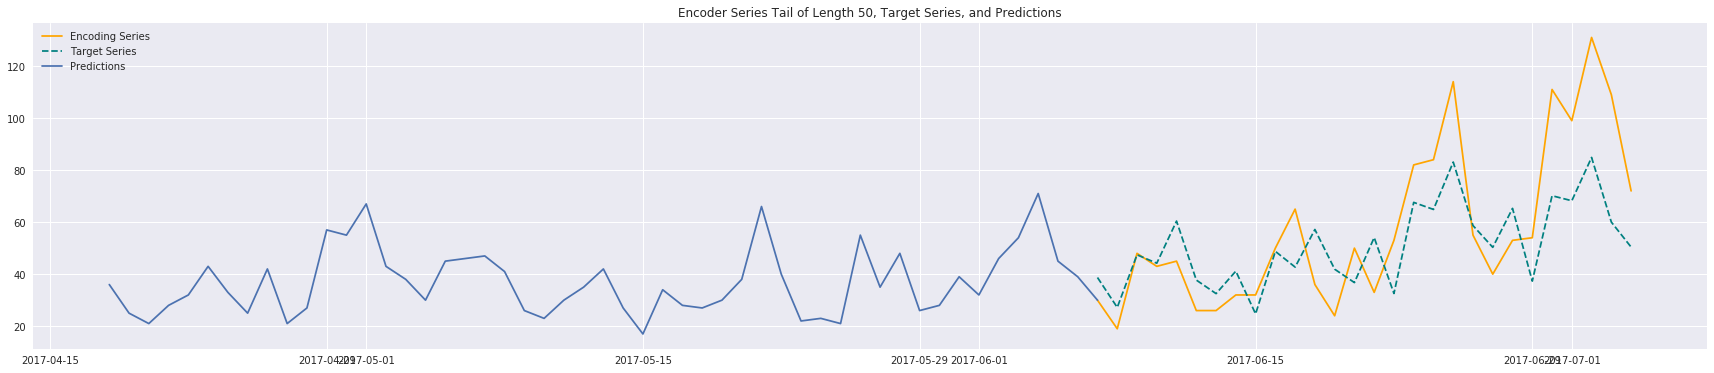

In [21]:
predict_and_plot(encoder_input_data, decoder_target_data, 0, actual=1)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,90.000000,95.000000,86.000000,159.000000,226.000000,87.000000,62.000000,71.000000,87.000000,117.000000,...,204.000000,89.000000,65.000000,71.000000,67.00000,109.000000,241.000000,260.000000,122.000000,160.00000
pred,138.128339,162.917362,160.385043,244.444972,279.374496,132.562707,115.244677,132.788589,142.292084,131.552261,...,224.242727,133.664592,121.859173,135.317713,132.07645,105.307484,203.031796,240.575846,139.277507,146.99279


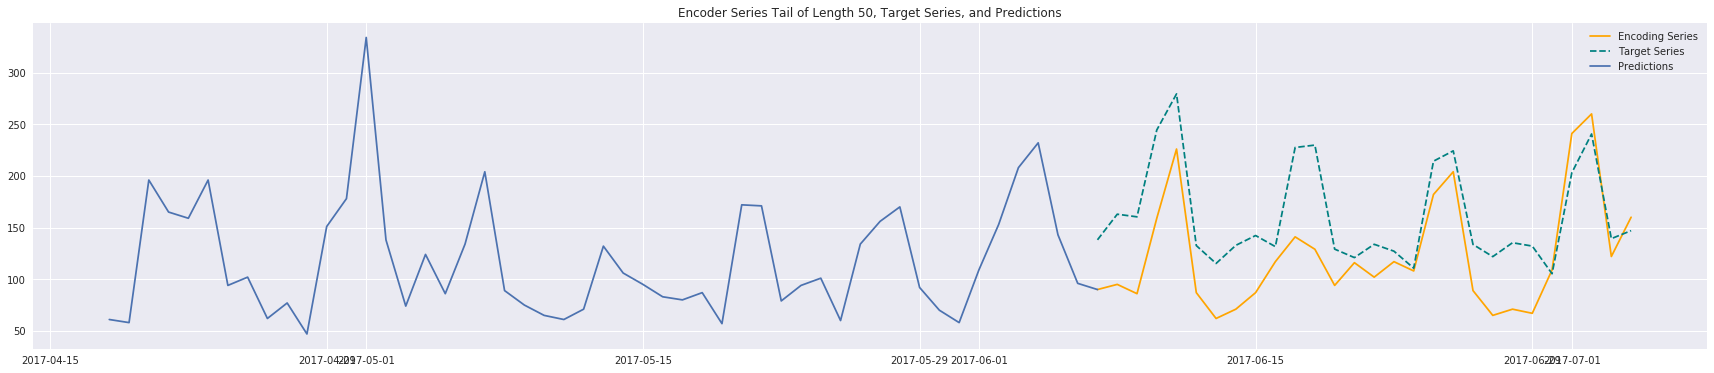

In [22]:
predict_and_plot(encoder_input_data, decoder_target_data, 1, actual=1)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,31.000000,32.0000,15.000000,28.000000,26.000000,33.000000,30.000000,33.000000,22.000000,26.000000,...,33.000000,18.000000,21.00000,24.000000,17.000000,30.000000,37.000000,35.000000,30.000000,32.000000
pred,39.492284,37.2959,29.130086,39.595935,28.997198,27.327259,34.426013,35.902668,33.486333,24.716247,...,33.638097,28.206659,29.98671,37.412801,32.966811,25.621356,24.694895,22.032811,21.013484,34.542621


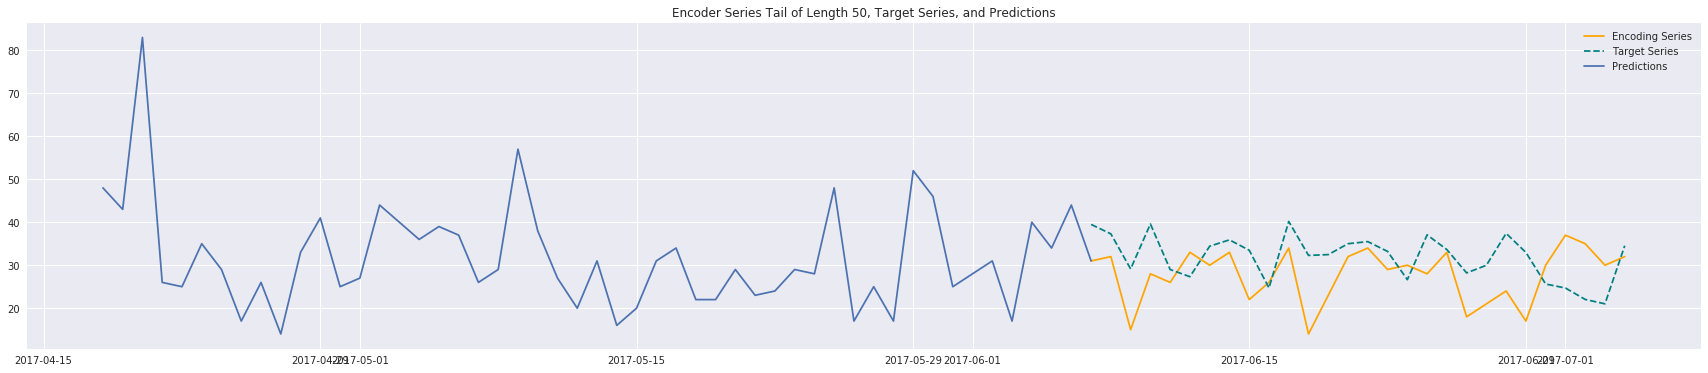

In [23]:
predict_and_plot(encoder_input_data, decoder_target_data, 2, actual=1)

ds,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,...,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00
actual,8.000000,12.000000,6.000000,18.000000,27.000000,7.000000,9.000000,8.00000,13.000000,17.00000,...,17.000000,9.000000,2.000000,14.000000,8.000000,16.000000,32.000000,29.000000,8.000000,11.000000
pred,11.825361,12.469577,17.094414,17.452867,16.469548,10.337423,9.832752,11.64321,12.034964,16.30682,...,15.429654,10.282264,9.886396,12.479929,11.554698,15.357388,20.472529,17.722283,9.901487,8.808615


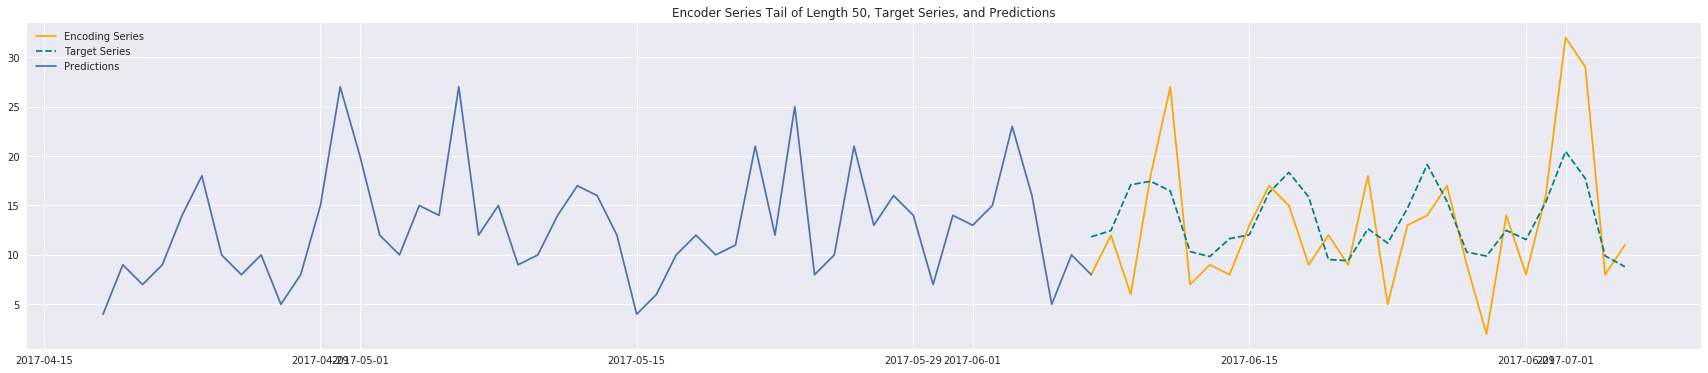

In [24]:
predict_and_plot(encoder_input_data, decoder_target_data, 3, actual=1)

# Evaluating Predictions Between val_pred_start, val_pred_end

In [25]:
def generate_val_pred_start_end_results(sample_ind):
    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)

    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 

    name = df['store_item'][sample_ind]
    raw_df = pd.DataFrame({
        'date': df.columns[-pred_steps:], 
        'actual': np.expm1(target_series + encode_series_mean[sample_ind]).flatten(),
        'pred': np.expm1(pred_series + encode_series_mean[sample_ind]).flatten()}
    )

    mae = mean_absolute_error(raw_df['actual'],raw_df['pred'])
    mape = mean_absolute_percentage_error(raw_df['actual'],raw_df['pred'])

    results = pd.DataFrame({
        'name': name,
        'mae': mae,
        'mape': mape,

    }, index=[sample_ind])


    results['raw'] = [raw_df]
    
    return results

In [26]:
val_results_df=pd.concat([generate_val_pred_start_end_results(sample_ind) for sample_ind in df.index])

In [27]:
val_results_df.describe()

,mae,mape
count,8715.000000,6060.000000
mean,7.236251,69.824123
std,8.751036,47.134197
min,0.695639,12.646101
25%,3.196077,41.394599
50%,4.704024,56.455706
75%,7.875185,82.917909
max,255.909863,723.387478
